# Auto Scorecard: Replicating SAS Enterprise Miner's Pipeline for Explainable Scorecards

In this tutorial, we will extend the FICO explainable scorecard to create a comprehensive pipeline that replicates commonly used steps in SAS Enterprise Miner. While we won't focus on manual binning, as it's covered in other tutorials on the Optbinning website, we aim to build an automated pipeline with the following functionalities:

1. Feature Reduction:
   - Removing features with small variance
   - Removing features with small Information Value (IV)
   - Identifying multicollinear features through clustering and selecting only two from each cluster
   - Utilizing recursive feature selection to narrow down to a parsimonious model with a handful of features

2. Scorecard Model:
   - Binning the features via Weight of Evidence (WOE)
   - Building a Logistic Regression model
   - Converting predictions to scores

For this tutorial, we assume you have the FICO data used in other tutorials and have already split it into train and test sets, placing them in the data folder. Our data folder should contain four files: _X_train.parquet_, _y_train.parquet_, _X_val.parquet_, and _y_val.parquet_.

The full pipeline looks like the figure below and can explored in here.

![Image](https://cdn-images-1.medium.com/max/800/1*o2NgTNpjrKg9wKU5RTkfQA.png)

## Note:
The code provided here was built for a blog post and contains additional information beyond a standard notebook code. For the complete version, please visit the blog and the associated repository.

Packages

In [17]:
import json
import logging as log
import os
from pathlib import Path

import pandas as pd
from optbinning import BinningProcess, Scorecard
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import RFECV, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from varclushi import VarClusHi


In [ ]:
# !pip install varclushi

In [18]:
log.basicConfig(format='%(levelname)s:%(message)s', encoding='utf-8', level=log.DEBUG)
TARGET: str = "RiskPerformance"
SPECIAL_CODES = [-9, -8, -7]
MISSING = [-99_000_000]
MAX_EIGEN = 0.7

This challenge imposes monotonicity constraints with respect to the probability of a bad target for many of the variables. We apply these rules by passing the following dictionary of parameters for these variables involved.


In [19]:
binning_fit_params = {
    "ExternalRiskEstimate": {"monotonic_trend": "descending"},
    "MSinceOldestTradeOpen": {"monotonic_trend": "descending"},
    "MSinceMostRecentTradeOpen": {"monotonic_trend": "descending"},
    "AverageMInFile": {"monotonic_trend": "descending"},
    "NumSatisfactoryTrades": {"monotonic_trend": "descending"},
    "NumTrades60Ever2DerogPubRec": {"monotonic_trend": "ascending"},
    "NumTrades90Ever2DerogPubRec": {"monotonic_trend": "ascending"},
    "PercentTradesNeverDelq": {"monotonic_trend": "descending"},
    "MSinceMostRecentDelq": {"monotonic_trend": "descending"},
    "NumTradesOpeninLast12M": {"monotonic_trend": "ascending"},
    "MSinceMostRecentInqexcl7days": {"monotonic_trend": "descending"},
    "NumInqLast6M": {"monotonic_trend": "ascending"},
    "NumInqLast6Mexcl7days": {"monotonic_trend": "ascending"},
    "NetFractionRevolvingBurden": {"monotonic_trend": "ascending"},
    "NetFractionInstallBurden": {"monotonic_trend": "ascending"},
    "NumBank2NatlTradesWHighUtilization": {"monotonic_trend": "ascending"}
}


## Feature Clustering

In this step, the features are clustered to group together those that carry similar information. From each cluster, we select only one feature. Usually, we choose the feature with the highest Information Value (IV) and the one located at the center of the cluster. To achieve this, we utilize the "varclushi" library, which functions similarly to the SAS version. We adapt it to work with a scikit-learn transformer pipeline, ensuring seamless integration into our pipeline.

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from pathlib import Path
from varclushi import VarClusHi
import json
import logging

log = logging.getLogger(__name__)

class Cluster(BaseEstimator, TransformerMixin):
    """
    Clustering Transformer for Feature Selection.

    This transformer clusters features based on their similarity and selects one feature from each cluster 
    based on the lowest RS Ratio. If available, the feature with the highest IV is also included. 
    It uses VarClusHi for clustering, a library that functions similarly to the SAS version.
    """

    def __init__(self, max_eigen=1, maxclus=None) -> None:
        """
        Initialize the Cluster transformer.

        Parameters:
            max_eigen (int, optional): Maximum number of eigenvalues for clustering. Defaults to 1.
            maxclus (int, optional): Maximum number of clusters to generate. Defaults to None.
        """
        self.max_eigen = max_eigen
        self.maxclus = maxclus

    def fit(self, x, y=None):
        """
        Fit the Cluster transformer to the data.

        Parameters:
            x (pd.DataFrame): Input data.
            y: Ignored.

        Returns:
            self: Fitted Cluster transformer object.
        """
        self.clusters = VarClusHi(df=x, maxeigval2=self.max_eigen, maxclus=self.maxclus)
        return self

    def transform(self, x):
        """
        Transform the input data based on feature selection.

        Parameters:
            x (pd.DataFrame): Input data.

        Returns:
            pd.DataFrame: Transformed data with selected features.
        """
        file = Path("data/pipeline/auto-iv-table.csv")
        if file.is_file():
            iv_table = self.read_iv_table(file).round(2)
        else:
            iv_table = None
        self.cluster_table = self.get_clusters(iv_table)
        self.selected_features = self.get_best_feature_from_each_cluster(
            cluster_table=self.cluster_table, feature="Variable"
        )
        cluster_table = self._indicated_selected(
            self.cluster_table, self.selected_features
        )
        Path("data/pipeline").mkdir(parents=True, exist_ok=True)
        cluster_table.to_csv("data/pipeline/cluster-iv-table.csv")
        return x[self.selected_features]

    @staticmethod
    def _indicated_selected(table, selected, features="Variable"):
        """
        Mark selected features in the cluster table.

        Parameters:
            table (pd.DataFrame): Cluster table.
            selected (list): List of selected features.
            features (str, optional): Name of the feature column. Defaults to "Variable".

        Returns:
            pd.DataFrame: Cluster table with marked selected features.
        """
        return table.assign(cluster_iv_selection=table[features].isin(selected))

    def get_clusters(self, iv_table=None):
        """
        Retrieve clusters with or without IV for each feature.

        Parameters:
            iv_table (pd.DataFrame, optional): IV table. Defaults to None.

        Returns:
            pd.DataFrame: Cluster table with or without IV.
        """
        self.clusters.varclus()
        self.iv_table = iv_table
        if self.iv_table is None:
            log.info("Retrieving clusters without IVs")
            return self.clusters.rsquare

        log.info("Retrieving clusters with IV for each feature")
        return pd.merge(
            self.clusters.rsquare.round(2),
            self.iv_table,
            how="left",
            left_on="Variable",
            right_on="name",
        )

    @staticmethod
    def get_best_feature_from_each_cluster(
        cluster_table: pd.DataFrame, feature: str = "Variable"
    ):
        """
        Get the best feature from each cluster.

        Parameters:
            cluster_table (pd.DataFrame): Cluster table with RS Ratio and IV.
            feature (str, optional): Name of the feature column. Defaults to "Variable".

        Returns:
            list: List of selected features.
        """
        if "iv" in cluster_table.columns:
            highest_iv = cluster_table.loc[
                cluster_table.groupby(["Cluster"])["iv"].idxmax()
            ][feature].tolist()
        else:
            highest_iv = []

        lowest_rs_ratio = cluster_table.loc[
            cluster_table.groupby(["Cluster"])["RS_Ratio"].idxmin()
        ][feature].tolist()

        return list(set(highest_iv + lowest_rs_ratio))

    @classmethod
    def read_iv_table(cls, path: Path | str, cutoff: float = 0.0):
        """
        Read IV table from a given path and filter based on a cutoff.

        Parameters:
            path (Path or str): Path to the IV table CSV file.
            cutoff (float, optional): IV cutoff value. Defaults to 0.0.

        Returns:
            pd.DataFrame: IV table after filtering.
        """
        return pd.read_csv(path).query(f"iv >= {cutoff}")

    @classmethod
    def save(cls, data: dict, path):
        """
        Save data to a given file path.

        Parameters:
            data (dict): Data to be saved.
            path (str): File path for saving the data.
        """
        with open(path, mode="w", encoding="utf-8") as f:
            json.dump(data, f, indent=6)


This improved Python code defines a transformer class called "Cluster," which performs feature selection through clustering based on similarity. It selects one feature from each cluster based on the lowest RS Ratio. The code uses VarClusHi library, similar to the SAS version, and integrates it into a scikit-learn transformer pipeline.

The `Cluster` class includes three main methods:

1. `fit`: Fits the clustering transformer to the input data.
2. `transform`: Transforms the input data based on feature selection and returns the data with selected features.
3. `get_best_feature_from_each_cluster`: Selects the best feature from each cluster based on the lowest RS Ratio and, if available, the highest IV.

The code also includes supporting methods for marking selected features in the cluster table, reading and filtering an IV table from a given path, and saving data to a file.

Overall, the "Cluster" class provides a comprehensive pipeline for feature selection through clustering, enhancing the explainable scorecard's capabilities in replicating SAS Enterprise Miner's steps.

## Feature reduction pipeline

In [21]:

def variable_reduction_pipeline(
    categorical_features: list[str],
    binning_features: list[str],
    binning_fit_params=None,
) -> Pipeline:
    """Create a scikit-learn pipeline for feature reduction using clustering.

    Args:
        categorical_features (list[str]): List of names of categorical features.
        binning_features (list[str]): List of names of features to apply binning.
        binning_fit_params (dict, optional): Fit parameters for binning process. Defaults to None.

    Returns:
        Pipeline: A scikit-learn pipeline for feature reduction.

    """
    binning_process = BinningProcess(
        categorical_variables=categorical_features,
        variable_names=binning_features,
        binning_fit_params=binning_fit_params,
        min_prebin_size=10e-5,  # The prebin size to make the feature set usable
        special_codes=SPECIAL_CODES,
        selection_criteria={"iv": {"min": 0.1}}
    )

    variance_reductor = VarianceThreshold().set_output(transform="pandas")
    clustering_process = Cluster(max_eigen=MAX_EIGEN)
    feature_selection = RFECV(
        LogisticRegression(max_iter=1000),
        cv=5,
        scoring="roc_auc",
        n_jobs=-1,
    )

    return Pipeline(
        [
            ('variance', variance_reductor),
            ('binning', binning_process),
            ('cluster', clustering_process),
            ('features', feature_selection),
        ]
    )


Explanation:

The provided Python code defines a function `variable_reduction_pipeline` that creates a scikit-learn pipeline for feature reduction using clustering. The pipeline comprises the following steps:

1. Binning Process: This step applies binning to the specified features using the `varclushi.BinningProcess`. It groups similar features based on information similarity and selects one feature from each cluster. Parameters like `categorical_features`, `binning_features`, and `binning_fit_params` are used to customize the binning process.

2. Variance Reduction: The pipeline uses `sklearn.feature_selection.VarianceThreshold` to eliminate features with little variance, which may not significantly contribute to the learning process or add noise to the model.

3. Clustering: The `varclushi.Cluster` is applied to perform clustering of the features, aiming to group together features with similar information content.

4. Recursive Feature Elimination with Cross-Validation (RFECV): This step utilizes `sklearn.feature_selection.RFECV` with `LogisticRegression` as the estimator. RFECV selects the most informative features by recursively eliminating the least significant features while performing cross-validation.

The function returns the complete pipeline, ready to be used for feature reduction and clustering, making it convenient for creating parsimonious models in credit risk modeling and similar applications.

## Scorecard Model

In [22]:
def model_pipeline(features, categorical_features, binning_fit_params=None):
    """
    Creates a pipeline for building a Scorecard model using the provided features and categorical features.

    Args:
        features (list): List of feature names.
        categorical_features (list): List of categorical feature names.
        binning_fit_params (dict, optional): Parameters for the binning process. Defaults to None.

    Returns:
        Scorecard: A Scorecard model pipeline.

    """
    binning_process = BinningProcess(
        categorical_variables=categorical_features,
        variable_names=features,
        binning_fit_params=binning_fit_params,
        min_prebin_size=10e-5,
        special_codes=SPECIAL_CODES,
        selection_criteria={"iv":{"min": 0.1}}
    )
    scaling_method: str = "pdo_odds"
    scaling_method_data = {
        "pdo": 30,
        "odds": 20,
        "scorecard_points": 750,
    }
    return Scorecard(
        binning_process=binning_process,
        estimator=LogisticRegression(),
        scaling_method=scaling_method,
        scaling_method_params=scaling_method_data,
        intercept_based=True,
        reverse_scorecard=False,
        rounding=True,
    )



**Explanation:**

The provided Python function `model_pipeline` creates a pipeline for building a Scorecard model using the specified features and categorical features. The function takes three arguments:

1. `features`: A list of feature names to be used in the model.
2. `categorical_features`: A list of categorical feature names.
3. `binning_fit_params` (optional): Parameters for the binning process. Default is set to None.

Inside the function, a `BinningProcess` object is created to handle the feature binning. It specifies the categorical variables, variable names, and binning fit parameters, among other options. The pipeline applies selection criteria, where features with Information Value (IV) less than 0.1 are discarded.

Next, the function sets the scaling method to "pdo_odds" and defines scaling method data with values for "pdo," "odds," and "scorecard_points."

Finally, a `Scorecard` model is returned, which uses the previously defined binning process, a Logistic Regression estimator, and additional scaling and rounding options to create the final Scorecard model pipeline.

## Other help functions

In [23]:
import os
from pathlib import Path
import pandas as pd

def get_data_and_columns(data_path="data"):
    """
    Load data and return the features and categorical columns.

    Args:
        data_path (str): Path to the data directory.

    Returns:
        x_train (pd.DataFrame): Training data features.
        y_train (numpy.ndarray): Training data target labels.
        features (list): List of all features.
        categorical_columns (list): List of categorical column names.
    """
    x_train = pd.read_parquet(os.path.join(data_path, "X_train.parquet"))
    y_train = pd.read_parquet(os.path.join(data_path, "y_train.parquet")).astype("int8").values.reshape(-1)

    categorical_columns = x_train.select_dtypes(include=["object", "category", "string"]).columns.tolist()
    features = x_train.columns.tolist()

    return x_train, y_train, features, categorical_columns


def save_pipeline_artifacts(pipe, scorecard):
    """
    Save the pipeline artifacts such as the model, IV table, and scorecard table.

    Args:
        pipe (dict): Dictionary containing pipeline components.
        scorecard (scorecardpy.ScoreCard): Scorecard model.
    """
    Path("data/pipeline").mkdir(parents=True, exist_ok=True)
    scorecard.save("data/pipeline/model.pkl")
    pipe["binning"].summary().to_csv("data/pipeline/auto-iv-table.csv")
    scorecard.table(style="detailed").round(3).to_csv("data/pipeline/scorecard-table.csv")


**Explanation**:

The first function, `get_data_and_columns`, loads the training data and returns the features and categorical columns. It reads the training data from the specified data path, converts the target labels to an array, and identifies the categorical columns based on their data types. The function returns the training data features, target labels, list of all features, and a list of categorical column names.

The second function, `save_pipeline_artifacts`, saves various pipeline artifacts. It creates a "pipeline" directory if it doesn't exist and saves the scorecard model as "model.pkl" within that directory. Additionally, it saves the IV (Information Value) table as "auto-iv-table.csv" and the scorecard table as "scorecard-table.csv" within the same directory. These artifacts are essential for further analysis and model evaluation.

## Main Entrypoint

In [24]:
import pandas as pd

def main(data_path: str, binning_fit_params: dict) -> tuple:
    """
    Clustering and Variable Reduction Pipeline

    This function performs clustering and variable reduction on the input data using the "varclushi" library.
    The input data and corresponding target labels are obtained from the specified data_path.
    Categorical and non-categorical features are determined, and the clustering pipeline is constructed.
    The model pipeline is then created based on the selected features, and both pipelines are fitted to the data.
    The selected features are stored, and the scorecard model's table is generated.
    Finally, the pipelines and model are saved as artifacts.

    Args:
        data_path (str): Path to the data directory containing training data.
        binning_fit_params (dict): Parameters for binning fitting.

    Returns:
        tuple: A tuple containing the scorecard model, the scorecard model's table, and the clustering pipeline.
    """

    x_train, y_train, features, categorical_columns = get_data_and_columns(
        data_path=data_path
    )

    # Clustering and variable reduction pipeline
    reductor_pipeline = variable_reduction_pipeline(
        categorical_features=categorical_columns,
        binning_features=features,
        binning_fit_params=binning_fit_params
    )
    reductor_pipeline.fit(X=x_train, y=y_train)

    selected_columns = (
        reductor_pipeline["features"].feature_names_in_
        [reductor_pipeline["features"].support_]
    )
    categorical_columns = list(set(selected_columns).intersection(categorical_columns))

    # Model pipeline
    scorecard_model = model_pipeline(
        features=selected_columns,
        categorical_features=categorical_columns,
        binning_fit_params=binning_fit_params
    )
    scorecard_model.fit(X=x_train, y=y_train)

    # Save artifacts
    save_pipeline_artifacts(pipe=reductor_pipeline, scorecard=scorecard_model)

    return scorecard_model, scorecard_model.table(), reductor_pipeline


**Explanation**:

The given Python code defines a main function that performs clustering and variable reduction on the input data using the "varclushi" library. The input data and corresponding target labels are obtained from the specified data_path. Categorical and non-categorical features are determined, and the clustering pipeline is constructed. The model pipeline is then created based on the selected features, and both pipelines are fitted to the data. The selected features are stored, and the scorecard model's table is generated. Finally, the pipelines and model are saved as artifacts, and the function returns a tuple containing the scorecard model, the scorecard model's table, and the clustering pipeline.

## Checking results

In [25]:
from sklearn.metrics import auc, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [ ]:
model, model_table, dim_reduction = main(data_path="data", binning_fit_params=binning_fit_params)

In [27]:
model_table

,Variable,Bin,Points
0,NumSatisfactoryTrades,"(-inf, 2.50)",0.0
1,NumSatisfactoryTrades,"[2.50, 5.50)",28.0
2,NumSatisfactoryTrades,"[5.50, 8.50)",40.0
3,NumSatisfactoryTrades,"[8.50, 11.50)",47.0
4,NumSatisfactoryTrades,"[11.50, 18.50)",54.0
...,...,...,...
9,NetFractionRevolvingBurden,"[73.50, 80.50)",8.0
10,NetFractionRevolvingBurden,"[80.50, 93.50)",3.0
11,NetFractionRevolvingBurden,"[93.50, inf)",0.0
12,NetFractionRevolvingBurden,Special,32.0


In [28]:
model_table.Variable.unique()

array(['NumSatisfactoryTrades', 'MaxDelq2PublicRecLast12M',
       'MSinceMostRecentInqexcl7days', 'ExternalRiskEstimate',
       'AverageMInFile', 'PercentInstallTrades',
       'NetFractionRevolvingBurden'], dtype=object)

In [29]:
model.table().Variable.unique()

array(['NumSatisfactoryTrades', 'MaxDelq2PublicRecLast12M',
       'MSinceMostRecentInqexcl7days', 'ExternalRiskEstimate',
       'AverageMInFile', 'PercentInstallTrades',
       'NetFractionRevolvingBurden'], dtype=object)

Show each features in and out of each stage.

In [30]:
for step, transformer in dim_reduction.steps:
    try:
        print(f"{step=} Features in: {dim_reduction[step].n_features_in_}, Features out: {dim_reduction[step].n_features_}")
    except Exception as e:
        pass

step='features' Features in: 9, Features out: 7


In [39]:
dim_reduction["features"].n_features_

7

Compute the ROC to compare with other tutorials in the website.

In [32]:
x_test = pd.read_parquet(os.path.join("data", "X_val.parquet"))
y_test = pd.read_parquet(os.path.join("data", "y_val.parquet")).astype("int8").values.reshape(-1)

In [33]:
probs = model.predict_proba(x_test)
preds = probs[:,1]
fpr1, tpr1, threshold = roc_curve(y_test, preds)
roc_auc1 = auc(fpr1, tpr1)

Text(0.5, 0, 'False Positive Rate')

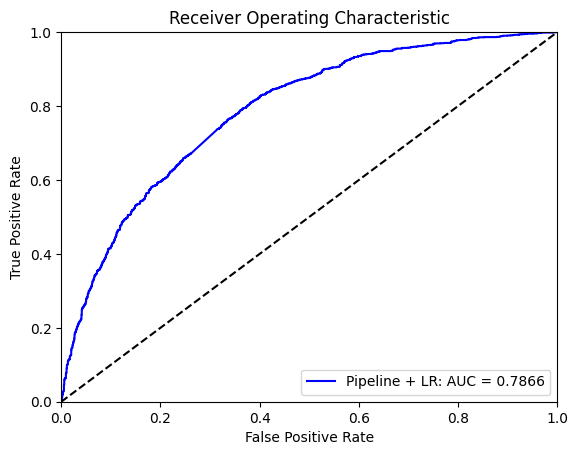

In [35]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label='Pipeline + LR: AUC = {0:.4f}'.format(roc_auc1))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')